# **Hands On Graph Neural Networks Using Python  -  CHAPTER 7**


- This code sets up and evaluates a Graph Attention Network (GAT) model using the Cora and CiteSeer datasets. It starts by installing necessary libraries and importing required modules.

- The SeedSetter class ensures reproducibility by setting random seeds. The GraphOperations class includes methods for performing graph convolutions, using attention mechanisms, and applying activation functions.

- The GAT class defines a GAT model with two layers of attention, a forward pass, and methods for training and testing. The DataVisualizer class provides methods for visualizing node degree distributions and model accuracy based on node degrees.

- The code performs the following steps: it initializes and trains a GAT model on the Cora dataset, evaluates its performance, and visualizes node degrees. It then does the same for the CiteSeer dataset, additionally plotting accuracy by node degree.

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 43.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 12.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import Counter
from torch.nn import Linear, Dropout
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import degree
from torch_geometric.datasets import Planetoid

### **SeedSetter Class**

- This class is responsible for setting random seeds to ensure reproducibility across different runs of the code.

- By fixing the seed for various random number generators (e.g., PyTorch, NumPy), it ensures that the results of the experiments remain consistent.

In [34]:
# Seed Setter
class SeedSetter:
    @staticmethod
    def set_seeds(seed=1):
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)

### **Graph Operations Class**

- This class contains static methods to perform graph convolution operations manually using NumPy.

- It includes a method for applying a custom graph convolution operation, a Leaky ReLU activation function, and a 2D softmax function.

- These operations are foundational to graph neural networks, particularly for processing node and edge features.

In [54]:
class GraphOperations:
    @staticmethod
    def graph_convolution(A, X, W, W_att):
        connections = np.where(A > 0)
        concat = np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis=1)
        a = W_att @ concat.T
        e = GraphOperations.leaky_relu(a)
        E = np.zeros(A.shape)
        E[connections[0], connections[1]] = e[0]
        W_alpha = GraphOperations.softmax2D(E, 1)
        H = A.T @ W_alpha @ X @ W.T
        return H

    @staticmethod
    def leaky_relu(x, alpha=0.2):
        return np.maximum(alpha * x, x)

    @staticmethod
    def softmax2D(x, axis):
        e = np.exp(x - np.expand_dims(np.max(x, axis=axis), axis))
        sum = np.expand_dims(np.sum(e, axis=axis), axis)
        return e / sum

### **GAT Model Class**

- This class implements a Graph Attention Network (GAT) using PyTorch Geometric's GATv2Conv layer.

- The model consists of two graph attention layers, with dropout and activation functions applied between them.

- The class includes methods for training the model on node classification tasks, testing its accuracy, and calculating the accuracy metric.


In [36]:
# GAT Model
class GAT(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=0.01)
        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = self.accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = self.accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = self.accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

    @staticmethod
    def accuracy(y_pred, y_true):
        return torch.sum(y_pred == y_true) / len(y_true)

### **Data Visualization Class**

- This class provides methods for visualizing data. It includes a method to plot the degree distribution of nodes in a graph, which shows how many nodes have a particular degree, and another method to plot accuracy scores against node degrees, helping to analyze how node connectivity affects model performance.

In [37]:
class DataVisualizer:
    @staticmethod
    def plot_degree_distribution(data):
        degrees = degree(data.edge_index[0]).numpy()
        numbers = Counter(degrees)
        fig, ax = plt.subplots()
        ax.set_xlabel('Node degree')
        ax.set_ylabel('Number of nodes')
        plt.bar(numbers.keys(), numbers.values())
        plt.show()

    @staticmethod
    def plot_accuracy_by_degree(degrees, accuracies, sizes):
        fig, ax = plt.subplots()
        ax.set_xlabel('Node degree')
        ax.set_ylabel('Accuracy score')
        plt.bar(['0', '1', '2', '3', '4', '5', '6+'], accuracies)
        for i in range(0, 7):
            plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='black')
        for i in range(0, 7):
            plt.text(i, accuracies[i] // 2, sizes[i], ha='center', color='white')
        plt.show()

In [50]:
# Set seeds
SeedSetter.set_seeds()

# Load Cora dataset
dataset_cora = Planetoid(root=".", name="Cora")
data_cora = dataset_cora[0]

### **Graph Convolution Operation Example**

In [51]:
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1]
  ])
X = np.random.uniform(-1, 1, (4, 4))
W = np.random.uniform(-1, 1, (2, 4))
W_att = np.random.uniform(-1, 1, (1, 4))
H = GraphOperations.graph_convolution(A, X, W, W_att)
print("Graph Convolution Output:\n", H)

Graph Convolution Output:
 [[ 1.91740248 -0.16073368]
 [ 1.01832447 -0.31917017]
 [ 1.37737072 -0.21103129]
 [ 1.37737072 -0.21103129]]


### **Create and Train GAT Model on Cora Dataset**

In [52]:
gat_cora = GAT(dataset_cora.num_features, 32, dataset_cora.num_classes)
print(gat_cora)
gat_cora.fit(data_cora, epochs=100)
acc_cora = gat_cora.test(data_cora)
print(f'GAT test accuracy on Cora: {acc_cora*100:.2f}%')

GAT(
  (gat1): GATv2Conv(1433, 32, heads=8)
  (gat2): GATv2Conv(256, 7, heads=1)
)
Epoch   0 | Train Loss: 1.969 | Train Acc: 15.00% | Val Loss: 1.96 | Val Acc: 11.80%
Epoch  20 | Train Loss: 0.259 | Train Acc: 96.43% | Val Loss: 1.10 | Val Acc: 67.60%
Epoch  40 | Train Loss: 0.163 | Train Acc: 98.57% | Val Loss: 0.90 | Val Acc: 70.80%
Epoch  60 | Train Loss: 0.205 | Train Acc: 98.57% | Val Loss: 0.96 | Val Acc: 69.00%
Epoch  80 | Train Loss: 0.130 | Train Acc: 100.00% | Val Loss: 0.91 | Val Acc: 70.80%
Epoch 100 | Train Loss: 0.148 | Train Acc: 99.29% | Val Loss: 0.90 | Val Acc: 73.20%
GAT test accuracy on Cora: 82.00%


### Plot Degree Distribution

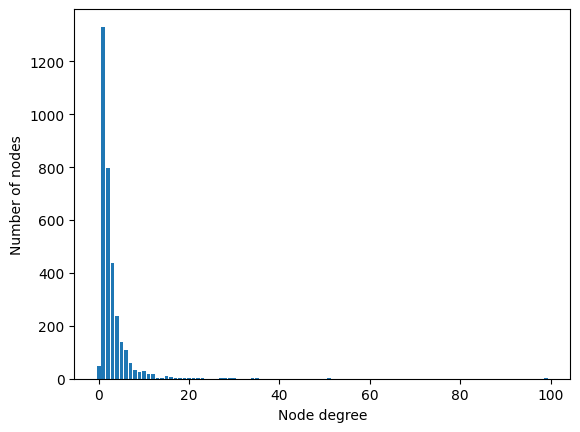

In [53]:
# Load CiteSeer dataset
dataset_citeseer = Planetoid(root=".", name="CiteSeer")
data_citeseer = dataset_citeseer[0]

# Plot Degree Distribution
DataVisualizer.plot_degree_distribution(data_citeseer)

### **Create and Train GAT Model on CiteSeer Dataset**

In [44]:
gat_citeseer = GAT(dataset_citeseer.num_features, 16, dataset_citeseer.num_classes)
print(gat_citeseer)
gat_citeseer.fit(data_citeseer, epochs=100)
acc_citeseer = gat_citeseer.test(data_citeseer)
print(f'GAT test accuracy on CiteSeer: {acc_citeseer*100:.2f}%')

GAT(
  (gat1): GATv2Conv(3703, 16, heads=8)
  (gat2): GATv2Conv(128, 6, heads=1)
)
Epoch   0 | Train Loss: 1.796 | Train Acc: 18.33% | Val Loss: 1.80 | Val Acc: 17.60%
Epoch  20 | Train Loss: 0.130 | Train Acc: 99.17% | Val Loss: 1.13 | Val Acc: 62.40%
Epoch  40 | Train Loss: 0.155 | Train Acc: 98.33% | Val Loss: 1.23 | Val Acc: 59.00%
Epoch  60 | Train Loss: 0.135 | Train Acc: 97.50% | Val Loss: 1.27 | Val Acc: 58.20%
Epoch  80 | Train Loss: 0.124 | Train Acc: 99.17% | Val Loss: 1.23 | Val Acc: 60.00%
Epoch 100 | Train Loss: 0.141 | Train Acc: 98.33% | Val Loss: 1.21 | Val Acc: 61.40%
GAT test accuracy on CiteSeer: 68.50%


In [49]:
out = gat_citeseer(data_citeseer.x, data_citeseer.edge_index)                                           # Get model's classifications
degrees = degree(data_citeseer.edge_index[0]).numpy()                                                   # Calculate the degree of each node
accuracies = []                                                                                         # Store accuracy scores and sample sizes
sizes = []

In [46]:
# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(gat_citeseer.accuracy(out.argmax(dim=1)[mask], data_citeseer.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(gat_citeseer.accuracy(out.argmax(dim=1)[mask], data_citeseer.y[mask]))
sizes.append(len(mask))

### **Plot Accuracy by Degree**

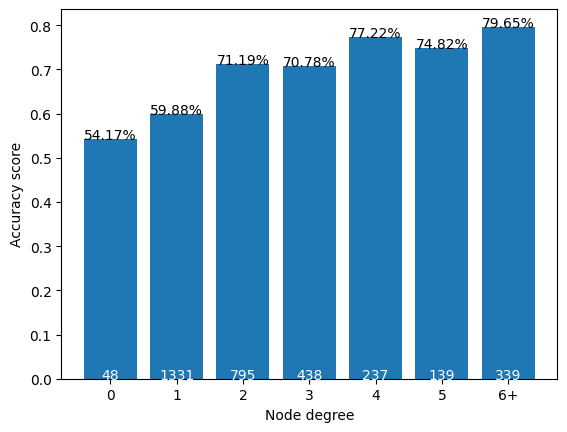

In [48]:
DataVisualizer.plot_accuracy_by_degree(degrees, accuracies, sizes)